In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 43kB/s 


In [2]:
!nvidia-smi

Sat Apr 10 15:29:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf

# **Import the libraries**

In [4]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout,Input, Lambda

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau



# from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [5]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.4.1


In [6]:
size = 32
model_name  = 'handwrittern bangla letter32 Dense121.h5'
batch_size = 16
IMAGE_SIZE = [size,size ]
path = '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/'

train_path = path + 'Train'
test_path = path + 'Test'

In [7]:

folders = glob(train_path + '/*')

folders

['/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/172',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/179',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/175',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/180',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/178',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/181',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/174',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/177',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/176',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/173',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/189',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/186',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/183',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/191',
 '/content/drive/MyDrive/Datasets/BasicFinalDatabase32/Train/1

In [8]:
# model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(size, size, 3,),classes=50,pooling='avg') 
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(size, size, 3,)) 
# model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(size, size, 3,)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(len(folders),activation='softmax')(x) #FC-layer

29089792/29084464 [==============================] - 1s 0us/step


In [9]:
model = Model(inputs=model_d.input, outputs=preds)
# model.summary()

In [10]:
# don't train existing weights
# for layer in model.layers:
#     layer.trainable = False


for layer in model.layers[:-4]:
    layer.trainable=False
    
for layer in model.layers[-4:]:
    layer.trainable=True

In [11]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [12]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint(model_name, verbose=1, save_best_only=False)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [13]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (size, size),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 12006 images belonging to 50 classes.


In [14]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (size, size),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 3000 images belonging to 50 classes.


In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  callbacks=[anne, checkpoint],
  validation_steps=len(test_set)
)

Epoch 1/50
751/751 [==============================] - 5488s 7s/step - loss: 3.3023 - accuracy: 0.2169 - val_loss: 1.4566 - val_accuracy: 0.5637

Epoch 00001: saving model to handwrittern bangla letter32 Dense121.h5
Epoch 2/50
751/751 [==============================] - 42s 56ms/step - loss: 2.0627 - accuracy: 0.4136 - val_loss: 1.2629 - val_accuracy: 0.6143

Epoch 00002: saving model to handwrittern bangla letter32 Dense121.h5
Epoch 3/50
751/751 [==============================] - 41s 55ms/step - loss: 1.8180 - accuracy: 0.4723 - val_loss: 1.1789 - val_accuracy: 0.6407

Epoch 00003: saving model to handwrittern bangla letter32 Dense121.h5
Epoch 4/50
751/751 [==============================] - 41s 55ms/step - loss: 1.7075 - accuracy: 0.5027 - val_loss: 1.1194 - val_accuracy: 0.6640

Epoch 00004: saving model to handwrittern bangla letter32 Dense121.h5
Epoch 5/50
751/751 [==============================] - 42s 56ms/step - loss: 1.6447 - accuracy: 0.5137 - val_loss: 1.0960 - val_accuracy: 0.6

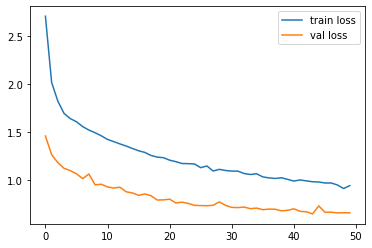

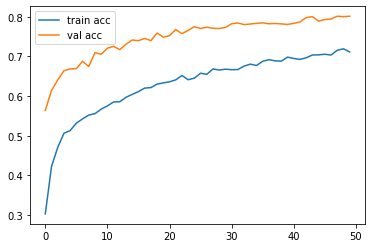

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [17]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model.save(model_name)

In [18]:
y_pred = model.predict(test_set)
y_pred

array([[1.40321078e-02, 1.16256485e-02, 5.28135616e-03, ...,
        5.36404375e-04, 5.78523963e-04, 2.16158410e-03],
       [3.58070756e-05, 2.43448835e-06, 3.27965157e-04, ...,
        2.66883708e-05, 3.37948695e-05, 6.02495766e-06],
       [5.28585497e-06, 4.60575939e-06, 2.39093322e-03, ...,
        1.80748293e-06, 1.37980087e-05, 3.83623001e-06],
       ...,
       [4.31674678e-04, 5.12558443e-04, 3.72070965e-04, ...,
        3.62370884e-05, 3.65570522e-05, 3.36992343e-05],
       [1.08568165e-05, 3.36913871e-07, 4.83879035e-08, ...,
        2.87901912e-07, 8.99040842e-08, 1.72307133e-04],
       [6.07343158e-03, 8.50814802e-04, 6.91259131e-02, ...,
        3.45900771e-04, 5.90593445e-05, 5.10366959e-03]], dtype=float32)

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model=load_model(model_name)
new_model = tf.keras.models.load_model(model_name)

# Check its architecture
new_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [20]:
loss, acc = new_model.evaluate(test_set, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


188/188 - 9s - loss: 0.6552 - accuracy: 0.8017
Restored model, accuracy: 80.17%
